<a href="https://colab.research.google.com/github/Omaam/gcl/blob/main/CrossSpectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## install and functions

In [ ]:
!pip install stingray

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import zscore
import stingray as stgr
from stingray.simulator import simulator
from stingray import Lightcurve, Crossspectrum, AveragedCrossspectrum

sns.set(style='whitegrid', context='talk')

In [3]:
def ccf(x, y, fs=1, maxlags=None):
    x = (x-np.mean(x)) / np.std(x)
    y = (y-np.mean(y)) / np.std(y)

    # calcurate correlation and lags
    n_x, n_y = len(x), len(y)
    r = signal.correlate(y, x, mode='full')
    r = r / (np.sqrt(n_x)*np.std(x)) / (np.sqrt(n_y)*np.std(y))
    lags = np.arange(-n_x + 1, n_y) / fs

    # query
    T = max(n_x, n_y)
    maxlags = 2 * T - 1 if maxlags is None else maxlags
    lag_out = lags[((-maxlags <= lags) & (lags <= maxlags))]
    r_out = r[((-maxlags <= lags) & (lags <= maxlags))]

    return lag_out, r_out

In [4]:
def symccf(a, base_side='left'):

    # make array
    corr_sym = np.copy(a) if base_side == 'left' else np.copy(a[::-1])

    # get center index + 1
    idx_med_m2 = int(np.floor(len(corr_sym)/2)) - 1
    idx_med_p1 = int(np.ceil(len(corr_sym)/2))

    # substitute
    corr_sym[idx_med_p1:] = corr_sym[idx_med_m2::-1]

    # substraction
    out = a - corr_sym

    return out

## main sequence

In [8]:
# make lightcurves
N = 2**14
lag = 2**2
sim = simulator.Simulator(N=N, mean=1., rms=0.2, dt=1, random_state=20210912)
base = sim.simulate(2)
original = base[lag:N]
deley = base[0:N-lag]

# lightcurves
A = [[1, 0],
      [0.8, 0.2]]
xs = np.array([original, deley])
lc1, lc2 = np.dot(A, xs)
time = np.arange(len(lc1))
lc1 = Lightcurve(time, lc1)
lc2 = Lightcurve(time, lc2)

/usr/local/lib/python3.7/dist-packages/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


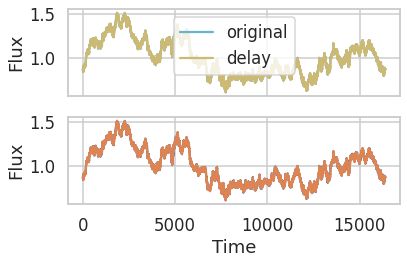

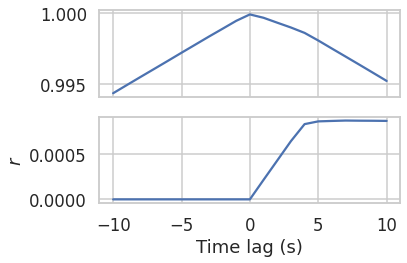

In [9]:
# summationed lightcurves
fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(original.counts, c='c', label='original')
ax[0].plot(deley.counts, c='y', label='delay')
ax[0].set_ylabel('Flux')
ax[0].legend(loc='best')

ax[1].plot(lc1)
ax[1].plot(lc2)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Flux')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, sharex=True)
lags, r = ccf(lc1.counts, lc2.counts, fs=1, maxlags=10)
r_sym = symccf(r)
ax[0].plot(lags, r)
ax[1].plot(lags, r_sym)
ax[1].set_xlabel('Time lag (s)')
ax[1].set_ylabel(r'$r$')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/stingray/utils.py:126: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
127it [00:00, 316.15it/s]
/usr/local/lib/python3.7/dist-packages/stingray/utils.py:126: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
127it [00:00, 292.83it/s]
/usr/local/lib/python3.7/dist-packages/stingray/utils.py:126: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
127it [00:00, 305.47it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


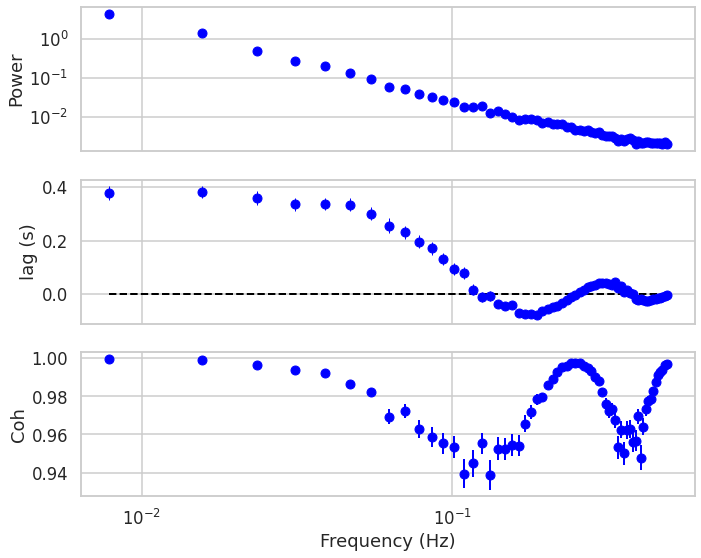

In [13]:
# Crosss-spectrum analysis
avg_cs = AveragedCrossspectrum(lc1, lc2, 128)
freq_lags, freq_lags_err = avg_cs.time_lag()

# figure: errorbar
fig, ax = plt.subplots(3, 1, figsize=(11, 9), sharex=True)

# power
ax[0].errorbar(avg_cs.freq, avg_cs.power, lw=2, color='blue', fmt='o')
ax[0].set_yscale('log')
ax[0].set_ylabel("Power")

# time lag
ax[1].hlines(0, avg_cs.freq[0], avg_cs.freq[-1], color='black', linestyle='dashed', lw=2)
ax[1].errorbar(avg_cs.freq, freq_lags, yerr=freq_lags_err, fmt="o", lw=1, color='blue')
ax[1].set_ylabel("lag (s)")

# coherence
coh, err_coh = avg_cs.coherence()
ax[2].errorbar(avg_cs.freq, coh, yerr=err_coh, lw=2, color='blue', fmt='o')
ax[2].set_xlabel("Frequency (Hz)")
ax[2].set_ylabel("Coh")
ax[2].set_xscale('log')

plt.show()